# Einsendeaufgabe 3: Numba (100 Punkte)

In diesem Abschnitt möchten wir unsere Applikationen mit Numba beschleunigen.

## Mandelbrot-Set (10 Punkte)

Wir beginnen mit einem klassischen Beispiel für Parallelisierung: dem Mandelbrot-Set.

Die Mandelbrot-Menge wird durch die Gleichung $z_{n+1} = z_n^2 + c$ beschrieben. In dieser Gleichung sind $c$ und $z$ komplexe Zahlen, und $n$ ist Null oder eine positive ganze Zahl. Ausgehend von $z_0=0$, gehört $c$ zur Mandelbrot-Menge, wenn der Absolutwert von $z_n$ niemals größer als eine bestimmte Zahl wird (diese Zahl ist abhängig von $c$), egal wie groß $n$ wird.

Das bedeutet, eine komplexe Zahl $c$ ist ein Element der Mandelbrotmenge, wenn die Beträge der mit diesem $c$ berechneten $z_{n}$ nicht unbegrenzt wachsen, unabhängig davon, wie groß $n$ wird. Es lässt sich leicht zeigen, dass der Betrag von $z_{n}$ unbegrenzt wächst, sobald ein $z_{n}$ mit $|z_{n}|>2$ auftritt.

Bei der Berechnung des Mandelbrot-Sets legt man oft eine obere Grenze für die maximalen Iterationen fest, um zu testen, ob diese überschritten wird.

Ein einfacher Algorithmus zur Bestimmung, ob ein Wert zum Mandelbrot-Set gehört, sieht folgendermaßen aus:

In [4]:
import numba
import numpy as np

400

In [ ]:
def escape_time(p, maxiter):
    """Perform the Mandelbrot iteration until it's clear that p diverges
    or the maximum number of iterations has been reached.

    Parameters
    ----------
    p: complex
        point in the complex plane
    maxiter: int
        maximum number of iterations to perform before p is considered in
        the Mandelbrot set.
    """
    z = np.zeros_like(p, dtype=np.complex128)
    for i in range(maxiter):
        z = z**2 + p
        abs_z = np.abs(z)
        if np.any(abs_z > 2):
            return i
    return maxiter


a = np.array([0.2 + 0.2j])
escape_time(a, 400)

Die Zahl $0.2+0.2j$ liegt also in der Mandelbrot Menge, da wir nach 400 Iterationen noch nicht die Abbruchbedingung erfüllen.  Allerdings ist es mühsam, jede Zahl einzeln zu testen. Wir erstellen also ein 2-D Feld mit vielen Komplexen Zahlen $|z|<2$: 

In [2]:
real_param = (-1.5, 1.1, 1500)
imag_param = (-1.5j, 1.1j, 1500)
XX, YY = np.meshgrid(np.linspace(*real_param), np.linspace(*imag_param))
P = XX + YY

<!-- BEGIN QUESTION -->

**Aufgabe:**  
- Vektorisieren Sie die Funktion mit `np.vectorize`
- Vektorisieren Sie die Funktion mit `numba.vectorize`
- Testen Sie, ob der Parallel-Parameter funktioniert und ob er Performance-Vorteile bringt
- Vergleichen Sie die Laufzeit der drei Versionen und stellen Sie den Vergleich graphisch dar

_Points:_ 7

In [7]:
import matplotlib.pyplot as plt
import time

maxiter = 200
start_time = time.time()

mandelbrot_set_np_vectorized = escape_time(P, maxiter)
np_vectorized_time = time.time() - start_time

start_time = time.time()
mandelbrot_set_numba_vectorized = escape_time(P, maxiter)
numba_vectorized_time = time.time() - start_time

start_time = time.time()
mandelbrot_set_numba_vectorized_par = escape_time(P, maxiter)
numba_vectorized_par_time = time.time() - start_time

In [ ]:
#maxiter = 200
...

<!-- END QUESTION -->

Mit *plt.imshow(M)* können Sie sich die Mandelbrotmenge $M$ ansehen: 

TypeError: Invalid shape () for image data

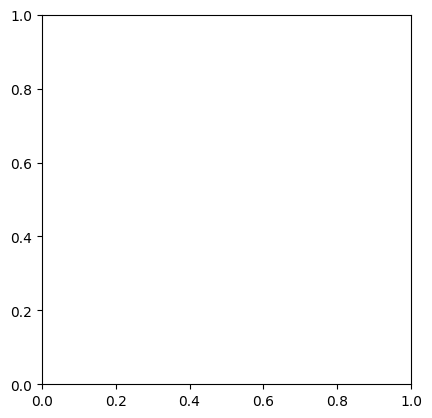

In [8]:
M = mandelbrot_set_numba_vectorized_par#(P, maxiter)
plt.imshow(M)

<!-- BEGIN QUESTION -->

**Aufgabe:** Vergleichen Sie nun die drei Versionen mit Scalene. Verwenden sie eine Sampling-Rate von $0.0001$

_Points:_ 3

In [ ]:
%load_ext scalene

In [ ]:
%%scalene --cpu-sampling-rate 0.0001
...

<!-- END QUESTION -->

## Springende Bälle, Teil 2 (60 Punkte)
Wir wollen die Simulation mit mehreren Bällen verbessern und optimieren. 

Jetzt werden zusätzlich Kollisionen zwischen den Bällen beachtet.
Dafür wollen wir zunächst berechnen, ob die Bälle in einem Zeitschritt kollidieren. Eine genaue Berechnung ist hier sehr schwer, daher können wir dies nur näherungsweise machen. Wir müssen dazu auch folgende Annahmen machen:

1. Die Bälle haben einen Radius von $r$, alle Bälle sind gleich groß 
2. Der Zeitschritt $\Delta t$ und die Geschwindigkeit $\$v$ der Bälle sind so gewählt, dass ein Ball maximal viermal seinen Radius in einem Zeitschritt zurücklegt, also $v*\Delta t <= 4*r$


Wir berechnen nun in jeden Zeitschritt zunächst 3 zusätzliche Zwischenzeitschritte:

$ c_0 = c_0$

$c_1 = c_0+0.25\Delta t *v$

$c_3 = c_0+0.5\Delta t *v$

$c_4 = c_0+0.75\Delta t * v$

(Der nächste Schritt wäre $\Delta t$, dieser wird aber in der nächsten Iteration beachtet.)


Wir betrachten nun jeweils für 2 Bälle, ob sie sich in einem der Zwischenzeitschritte näher als zweimal dem Radius $r$ kommen. Wenn sie das tun, gibt es eine Kollision.

<!-- BEGIN QUESTION -->

**Aufgabe:** Schreiben Sie eine Funktion, die dies für zwei Bälle testet und zunächst `True` oder `False` zurück gibt. Für die Berechnung des Abstands können sie die Funktion `np.linalg.norm` verwenden.

_Points:_ 10

In [2]:
def will_collide(c1, v1, c2, v2, r, dt):
    """
    Testet ob zwei Bälle kollidieren.
    Parameter:
        c1: Position des ersten Balls.
        v1: Geschwindigkeit des ersten Balls.
        c2: Position des zweiten Balls.
        v1: Geschwindigkeit des zweiten Balls.
        r: Radius der Bälle.
        dt: Duration des timestep.
    """
    # Berechnen der Zwischenzeiten gem. Vogabe
    c1_intermediate = [
        c1,
        c1 + 0.25 * dt * v1,
        c1 + 0.5 * dt * v1,
        c1 + 0.75 * dt * v1,
        c1 + dt * v1
    ]
    
    c2_intermediate = [
        c2,
        c2 + 0.25 * dt * v2,
        c2 + 0.5 * dt * v2,
        c2 + 0.75 * dt * v2,
        c2 + dt * v2
    ]
    # Überprüfe Abstände in den Zwischenzeitschritten
    for i in range(5):
        if np.linalg.norm(c1_intermediate[i] - c2_intermediate[i]) < 2 * r:
            return True
        return False

In [3]:
# Test
# Beispiel für die Nutzung der Funktion
c1 = np.array([0.0, 0.0])
v1 = np.array([1.0, 0.0])
c2 = np.array([3.0, 0.0])
v2 = np.array([-1.0, 0.0])
r = 0.5
dt = 1.0

collision = will_collide(c1, v1, c2, v2, r, dt)
print(f"Collision: {collision}")

Collision: False


<!-- END QUESTION -->

Um die Geschwindigkeiten der Bälle nach einer Kollision zu berechnen, können wir die Erhaltung des Impulses und die Erhaltung der kinetischen Energie heranziehen, unter der Annahme, dass es sich um eine vollkommen elastische Kollision handelt. Bei einer solchen Kollision bleiben sowohl der Gesamtimpuls als auch die gesamte kinetische Energie des Systems erhalten. Die Berechnungen werden allerdings etwas komplexer, wenn wir Richtungen berücksichtigen.

#### Geschwindigkeiten nach der Kollision

Für zwei Bälle mit Massen $m_1$ und $m_2$, den Anfangsgeschwindigkeiten $v_1$ und $v_2$ und den Endgeschwindigkeiten $v_1'$ und $v_2'$ gelten folgende Gleichungen basierend auf dem Impulserhaltungssatz und der Erhaltung der kinetischen Energie:

1. **Impulserhaltung:**
   $m_1 v_1 + m_2 v_2 = m_1 v_1' + m_2 v_2'$

2. **Erhaltung der kinetischen Energie:**
   $\frac{1}{2} m_1 v_1^2 + \frac{1}{2} m_2 v_2^2 = \frac{1}{2} m_1 {v_1'}^2 + \frac{1}{2} m_2 {v_2'}^2$

Diese Gleichungen müssen vektoriell gelöst werden, da die Geschwindigkeiten Richtungen haben.

Die Lösungen für die Geschwindigkeiten nach der Kollision in zwei Dimensionen unter der Annahme einer vollkommen elastischen Kollision und unter Ignorierung der Rotation der Bälle sind:

$v_1' = v_1 - \frac{2 m_2}{m_1 + m_2} \frac{(v_1 - v_2) \cdot (c_1 - c_2)}{\|c_1 - c_2\|^2} (c_1 - c_2)$

$v_2' = v_2 + \frac{2 m_1}{m_1 + m_2} \frac{(v_1 - v_2) \cdot (c_1 - c_2)}{\|c_1 - c_2\|^2} (c_1 - c_2)$

Hierbei ist $(v_1 - v_2) \cdot (c_1 - c_2)$ das Skalarprodukt der Vektoren $v_1 - v_2$ und $c_1 - c_2$, und $\|c_1 - c_2\|$ ist der Betrag des Vektors $(c_1 - c_2)$, welcher den Abstand zwischen den Zentren der Bälle darstellt.


<!-- BEGIN QUESTION -->

**Aufgabe:** Schreiben Sie eine Funktion, welche die neuen Geschwindigkeiten der Bälle NACH einer Kollision berechnet.  
Sie übergeben der Funktion die folgenden Daten.
- Koordinaten ($c_1, c_2$)
- Geschwindigkeiten ($v_1, v_2$)
- Massen ($m_1, m_2$)

Für die Berechnung des Betrags können Sie wiederum die Funktion `np.linalg.norm` verwenden.

_Points:_ 10

In [4]:
def collision(c1, c2, v1, v2, m1, m2):
    """Elastischer Stoß zwischen den Bällen 1 und 2.
    
    Parameter:
        c1: Position des ersten Balls.
        v1: Geschwindigkeit des ersten Balls.
        c2: Position des zweiten Balls.
        v1: Geschwindigkeit des zweiten Balls.
        m1: Masse des ersten Balls.
        m2: Masse des zweiten Balls.
    Returns:
        tuple mit den neuen Geschwinigkeiten der Bälle nach einer Kollission.
    """
    # Vektor mit relativen Geschwindikeiten und Positionen
    delta_v = v1-v2
    delta_c = c1-c2
    
    # Skalarprodukt von delta_v und delta_c
    dot_product = np.dot(delta_v, delta_c)
    
    # Normierung des Positionsvektors
    norm_squared = np.linalg.norm(delta_c)**2
    
    # Berechnung der neuen Geschwindigkeiten
    v1_new = v1 - (2 * m2 / (m1 + m2)) * (dot_product / norm_squared) * delta_c
    v2_new = v2 + (2 * m1 / (m1 + m2)) * (dot_product / norm_squared) * delta_c
    
    
    return v1_new, v2_new


def test_collision(case):
    # Online simulator
    # https://phet.colorado.edu/sims/html/collision-lab/latest/collision-lab_all.html
    if case == "x":
        c1 = np.array([1, 1])
        c2 = np.array([2, 1])
        v1 = np.array([1, 0])
        v2 = np.array([-1, 0])
    if case == "y":
        c1 = np.array([1, 1])
        c2 = np.array([1, 2])
        v1 = np.array([0, 1])
        v2 = np.array([0, -1])
    if case == "diagonal":
        c1 = np.array([1, 1])
        c2 = np.array([2, 2])
        v1 = np.array([1, 1])
        v2 = np.array([0, 0])
    if case == "custom":
        c1 = np.array([1, 1])
        c2 = np.array([2, 3])
        v1 = np.array([1, 1])
        v2 = np.array([0, -1])
    v1_new, v2_new = collision(c1, c2, v1, v2, 1, 1)
    assert np.allclose(np.abs(v2 - v1), np.abs(v2_new - v1_new))
    print(f"{v1=}, {v2=}, {v1_new=}, {v2_new=}")

    # different mass
    v1_new, v2_new = collision(c1, c2, v1, v2, 1, 20)
    assert np.allclose(np.abs(v2 - v1), np.abs(v2_new - v1_new))
    print(f"{v1=}, {v2=}, {v1_new=}, {v2_new=}")


test_collision(case="x")
test_collision(case="y")
test_collision(case="diagonal")
test_collision(case="custom")

v1=array([1, 0]), v2=array([-1,  0]), v1_new=array([-1.,  0.]), v2_new=array([1., 0.])
v1=array([1, 0]), v2=array([-1,  0]), v1_new=array([-2.80952381,  0.        ]), v2_new=array([-0.80952381,  0.        ])
v1=array([0, 1]), v2=array([ 0, -1]), v1_new=array([ 0., -1.]), v2_new=array([0., 1.])
v1=array([0, 1]), v2=array([ 0, -1]), v1_new=array([ 0.        , -2.80952381]), v2_new=array([ 0.        , -0.80952381])
v1=array([1, 1]), v2=array([0, 0]), v1_new=array([2.22044605e-16, 2.22044605e-16]), v2_new=array([1., 1.])
v1=array([1, 1]), v2=array([0, 0]), v1_new=array([-0.9047619, -0.9047619]), v2_new=array([0.0952381, 0.0952381])
v1=array([1, 1]), v2=array([ 0, -1]), v1_new=array([ 2.22044605e-16, -1.00000000e+00]), v2_new=array([1., 1.])
v1=array([1, 1]), v2=array([ 0, -1]), v1_new=array([-0.9047619 , -2.80952381]), v2_new=array([ 0.0952381 , -0.80952381])


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Aufgabe:** Nun wollen wir eine Funktion implementieren, die alle möglichen Kollisionen in einem Zeitschritt erfasst und die neuen Geschwindigkeiten der Bälle berechnet – und zwar möglichst effizient. 

Dafür sollten Sie die folgenden Dinge beachten:
1. Es macht nicht für alle Ballpaare sinnvoll alle vier Zwischenzeitschritte zu berechnen. Testen Sie daher zunächst, ob sich zwei Bälle bereits näher als $ 8 \cdot r $ sind.
2. Sie können annehmen, dass sich der Ball bis zum Zwischenschritt, in dem die Kollision berechnet wird, mit der alten Geschwindigkeit bewegt, danach mit der neuen. Implementieren Sie dies entsprechend. Achten Sie auch darauf, dass ein Ball, für den eine Kollision berechnet wurde, im selben Zeitschritt keine vollständige Bewegung für $ \Delta t $ mehr macht.
3. Es kann leicht passieren, dass zwei Bälle, die in einem Zeitschritt kollidieren, es nicht schaffen, sich während des Zeitschritts weit genug aufeinander zu bewegen, sodass sie im folgenden Zeitschritt wieder miteinander kollidieren. Das kann dann dazu führen, dass die Bälle sich umkreisen. Um das zu verhindern, verwenden wir eine Maske (`mask`), die dafür sorgt, dass zwei Bälle nicht in zwei (oder mehr) aufeinanderfolgenden Zeitschritten miteinander kollidieren können.

Anmerkung: Die Situation, dass mehrere Bälle gleichzeitig, in einem Zeitschritt kollidieren, kann hier vereinfacht ignoriert werden.

_Points:_ 10

In [5]:
def get_all_collisions(c, v, m, r, dt, mask):
    """
    Erfasst alle möglichen Kollissionen in einem Zeitschritt und berechnet die neuen Geschwindigkeiten
    der Bäle.
    Parameter:
        c: Positionen der Bälle als Array.
        v: Geschwindigkeiten der Bälle als Array.
        m: Massen der Bälle.
        r: Radius der Bälle.
        dt: Dauer eines Zeitschritts.
        mask: Maske zur Vermeidung von wiederholten Kollissionen als Array.
    Return: Tuple mit neuen Geschwinigkeiten der beteiligten Bälle.
    """
    N = c.shape[0]
    for i in range(N):
        for j in range(i + 1, N):
            if mask[i, j] > 0:
                mask[i, j] -= 1
                continue
            if np.linalg.norm(c[i] - c[j]) < 8 * r:
                if will_collide(c[i], v[i], c[j], v[j], r, dt):
                    v[i], v[j] = collision(c[i], c[j], v[i], v[j], m[i], m[j])
                    mask[i, j] = 1  # Kollisionen im nächsten Zeitschritt vermeiden!

    # Aktualisiere Positionen nach dem Zeitschritt
    c += v * dt
    return c, v
    
    

In [6]:
import numpy as np

# Anfangsbedingungen (Vorschlag)
g = np.array([0, -9.81], dtype=np.float64)
xmax = 1000
ymax = 1000
steps = 2000
dt = xmax * 1e-5
# Anzahl Bälle
N = 20

# Durchmesser Ball
r = xmax * dt
print(r)
rng = np.random.default_rng(seed=123)


# Startpositionen
def init(n=N):
    c = xmax * rng.random((N, 2))
    # Startgeschwindigkeiten, max.
    v = np.array([xmax, ymax]) * rng.random((N, 2))
    # Masse
    m = np.full(N, 0.05)
    mask = np.full((N, N), 0, np.int32)
    return c, v, m, mask

10.0


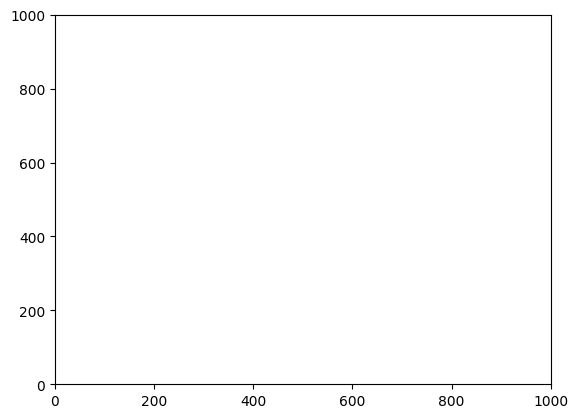

In [10]:
# Initialisierung
c, v, m, mask = init()

# Ergebnisse speichern
positions = [c.copy()]

# Simulation
for step in range(steps):
    c, v = get_all_collisions(c, v, m, r, dt, mask)
    positions.append(c.copy())

import matplotlib.pyplot as plt
import matplotlib.animation as animation
    
# Visualisierung der Bewegung der Bälle
fig, ax = plt.subplots()
ax.set_xlim(0, xmax)
ax.set_ylim(0, ymax)
scat = ax.scatter([], [])

def init_plot():
    scat.set_offsets(np.empty((0, 2)))
    return scat,

def update_plot(frame):
    scat.set_offsets(positions[frame])
    return scat,

ani = animation.FuncAnimation(fig, update_plot, frames=len(positions), init_func=init_plot, blit=True, interval=dt*1000, repeat=False)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Aufgabe:** Implementieren Sie nun einen vollständigen Zeitschritt mit Kollisionen. 

_Points:_ 10

In [12]:
def timestep_with_collisions(c, v, m, dt, g, xmax, ymax, mask):
    """
    Simulate a timestep for multiple balls with collisions.

    Parameters:
        c: Positionen der Bälle, shape (N, 2).
        v: Geschwindigkeiten der Bälle, shape (N, 2).
        m: Massen der Bälle, shape (N,).
        dt: Dauer eines Zeitschritts.
        g: Beschleunigung durch die Schwerkraft, shape (2,).
        xmax: Maximale x-Koordinate der Box.
        ymax: Maximale y-Koordinate der Box.
        mask: Maske zur Vermeidung von wiederholten Kollisionen, shape (N, N).
        
    Returns:
        tuple: Neue Positionen und Geschwindigkeiten der Bälle.
    """
    # Update Geschwindigkeiten durch die Schwerkraft
    v[:, 1] += g[1] * dt

    # Berechne Kollisionen und aktualisiere Geschwindigkeiten
    c, v = get_all_collisions(c, v, m, r, dt, mask)

    # Update Positionen
    c += v * dt

    # Reflektiere die Bälle an den Wänden
    mask_x_neg = c[:, 0] < 0
    mask_x_pos = c[:, 0] > xmax
    v[mask_x_neg | mask_x_pos, 0] = -v[mask_x_neg | mask_x_pos, 0]
    c[mask_x_neg, 0] = -c[mask_x_neg, 0]
    c[mask_x_pos, 0] = 2 * xmax - c[mask_x_pos, 0]

    mask_y_neg = c[:, 1] < 0
    mask_y_pos = c[:, 1] > ymax
    v[mask_y_neg | mask_y_pos, 1] = -v[mask_y_neg | mask_y_pos, 1]
    c[mask_y_neg, 1] = -c[mask_y_neg, 1]
    c[mask_y_pos, 1] = 2 * ymax - c[mask_y_pos, 1]

    return c, v


In [13]:
c, v, m, mask = init()
timestep_with_collisions(c, v, m, dt, g, xmax, ymax, mask)

(array([[532.78692735,  90.35694717],
        [ 92.20316704, 696.35620316],
        [972.28426601, 511.76000921],
        [  8.54800794, 840.67139682],
        [845.32622265, 351.36637837],
        [685.67078893, 148.16653506],
        [166.38494607, 726.01633226],
        [515.23662798, 598.53210784],
        [541.700366  , 940.59424029],
        [805.82604886, 913.91838906],
        [304.51662834, 987.75020184],
        [831.25812929, 118.53619535],
        [ 89.01259496, 192.87451473],
        [343.18458093, 221.49690435],
        [ 70.195278  , 460.75873181],
        [265.68022614, 470.14051162],
        [791.79530092, 340.85916825],
        [ 46.88738353, 844.1401817 ],
        [500.89775012, 259.78296194],
        [945.618207  , 748.60858064]]),
 array([[421.70396425, 347.02563465],
        [ 71.05178877, 285.55420418],
        [715.82943107,  75.53677472],
        [376.47794947, 591.47344299],
        [739.95652385, 742.72441063],
        [292.60787717, 329.14429508],
        [1

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Aufgabe:** Animieren Sie die Bewegung der Bälle.

Tipp: Trennen Sie Simulation und Visualisierung und visualisieren Sie z.B. nur jeden 100. Simulationsschritt. 

_Points:_ 5

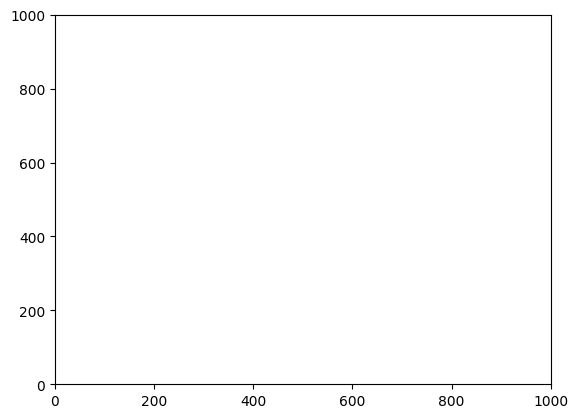

In [14]:
# Simulation
for step in range(steps):
    c, v = timestep_with_collisions(c, v, m, dt, g, xmax, ymax, mask)
    if step % 100 == 0:
        positions.append(c.copy())

# Visualisierung der Bewegung der Bälle
fig, ax = plt.subplots()
ax.set_xlim(0, xmax)
ax.set_ylim(0, ymax)
scat = ax.scatter([], [])

def init_plot():
    scat.set_offsets(np.empty((0, 2)))
    return scat,

def update_plot(frame):
    scat.set_offsets(positions[frame])
    return scat,

ani = animation.FuncAnimation(fig, update_plot, frames=len(positions), init_func=init_plot, blit=True, interval=dt*1000, repeat=False)

plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Aufgabe:** Analysieren Sie nun die Simulation mit Scalene. Was hat sich gegenüber der alten Version ohne die Kollisionen verändert? 

_Points:_ 5

_Type your answer here, replacing this text._

In [ ]:
c, v, m, mask = init(10)

In [ ]:
%%scalene --cpu-sampling-rate 0.01
...

In [ ]:
c, v, m, mask = init(300)

In [ ]:
%%scalene --cpu-sampling-rate 0.01
...

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Aufgabe:** Versuchen Sie Ihren Code (d.h. `timestep_with_collisions`) zu optimieren, damit er besser skaliert.

Vergleichen Sie danach die Ausführungszeiten beider Varianten für 20 Zeitschritte mit $[100, 200,300]$ Bällen.

Stellen Sie den Vergleich graphisch dar.

_Points:_ 10

In [ ]:
## Optimized CODE
import numba


...

In [ ]:
c, v, m, mask = init()
timestep_with_collisions_numba(c, v, m, dt, g, xmax, ymax, mask)

In [ ]:
...

In [ ]:
...

<!-- END QUESTION -->

## Optimierung des Gauß-Verfahrens (30 Punkte)

<!-- BEGIN QUESTION -->

**Aufgabe:** Optimieren Sie die Funktionen `lu_decomposition` und `custom_solve` aus der zweiten Einsendeaufgabe mit Hilfe von Numba.

An welcher Stelle ist die Verwendung von `prange` richtig und sinnvoll? 

Vergleichen Sie die Performance vor und nach der Optimierung für Gleichungssysteme der Größe $256\times 256 $ und $512 \times 512$.

Stellen Sie den Vergleich graphisch dar.

_Points:_ 30

In [10]:
from numba import prange, jit
import numpy as np
import time
import matplotlib.pyplot as plt

@jit(nopython=True)
def lu_decomposition(A):
    """
    Implement LU-Decomposition of a square matrix.
    This function works in-place i.e. it stores information about L and U in A and returns the pivot vector.
    """
    n = A.shape[0]
    p = np.arange(n)

    for i in prange(n):
        max_row = i + np.argmax(np.abs(A[i:n, 1]))
        if i != max_row:
            A[[i, max_row], :] = A[[max_row, i], :]
            p[[i, max_row]] = p[[max_row, i]]
        
        for j in range(i + 1, n):
            A[j, i] /= A[i, i]
            A[j, i+1:] -= A[j, i] * A[i, i+1:]
    return p
#Performance Vergleich 
A1 = np.random.rand(256, 256)
A2 = np.random.rand(512, 512)

start = time.time()
lu_decomposition(A1)
end = time.time()
time1 = end - start

start = time.time()
lu_decomposition(A2)
end = time.time()
time2 = end - start

sizes = [256, 512]
times = [time1, time2]

plt.plot(sizes, times)
plt.xlabel('Matrix Size (n x n)')
plt.ylabel('Time (s)')
plt.title('LU Decomposition Performance Comparison')
plt.show()

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(array(float64, 2d, C), Tuple(list(int64)<iv=None>, slice<a:b>))
 
There are 22 candidate implementations:
   - Of which 20 did not match due to:
   Overload of function 'getitem': File: <numerous>: Line N/A.
     With argument(s): '(array(float64, 2d, C), Tuple(list(int64)<iv=None>, slice<a:b>))':
    No match.
   - Of which 2 did not match due to:
   Overload in function 'GetItemBuffer.generic': File: numba/core/typing/arraydecl.py: Line 211.
     With argument(s): '(array(float64, 2d, C), Tuple(list(int64)<iv=None>, slice<a:b>))':
    Rejected as the implementation raised a specific error:
      NumbaTypeError: Unsupported array index type list(int64)<iv=None> in Tuple(list(int64)<iv=None>, slice<a:b>)
  raised from /usr/local/lib/python3.11/site-packages/numba/core/typing/arraydecl.py:104

During: typing of intrinsic-call at /tmp/ipykernel_70/3988577554.py (18)

File "../../../tmp/ipykernel_70/3988577554.py", line 18:
<source missing, REPL/exec in use?>


In [12]:
import numpy as np
from numba import jit, prange
import time
import matplotlib.pyplot as plt

@jit(parallel=True)
def custom_solve(A, b):
    """Solve a system of linear equations A * x = b and return result vector x."""
    A = A.copy()
    p = lu_decomposition(A)

    b = b[p]

    n = A.shape[0]
    x = np.zeros_like(b)
    y = np.zeros_like(b)

    for i in prange(n):
        y[i] = b[i] - np.dot(A[i, :i], y[:i])
    
    for i in prange(n-1, -1, -1):
        x[i] = (y[i] - np.dot(A[i, i+1:], x[i+1:])) / A[i, i]
    
    return x

A1 = np.random.rand(256, 256)
b1 = np.random.rand(256)
A2 = np.random.rand(512, 512)
b2 = np.random.rand(512)

times = []

# Messung der Zeit vor der Optimierung
start = time.time()
custom_solve(A1, b1)
custom_solve(A2, b2)
end = time.time()
times.append(end-start)

# Messung der Zeit nach der Optimierung
start = time.time()
custom_solve(A1, b1)
custom_solve(A2, b2)
end = time.time()
times.append(end-start)

labels = ['Vor der Optimierung', 'Nach der Optimierung']
x_pos = np.arange(len(labels))

plt.bar(x_pos, times, align='center', alpha=0.5)
plt.xticks(x_pos, labels)
plt.ylabel('Zeit (s)')
plt.title('Berechnungszeit vor und nach der Optimierung')
plt.show()

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(array(float64, 2d, C), Tuple(list(int64)<iv=None>, slice<a:b>))
 
There are 22 candidate implementations:
   - Of which 20 did not match due to:
   Overload of function 'getitem': File: <numerous>: Line N/A.
     With argument(s): '(array(float64, 2d, C), Tuple(list(int64)<iv=None>, slice<a:b>))':
    No match.
   - Of which 2 did not match due to:
   Overload in function 'GetItemBuffer.generic': File: numba/core/typing/arraydecl.py: Line 211.
     With argument(s): '(array(float64, 2d, C), Tuple(list(int64)<iv=None>, slice<a:b>))':
    Rejected as the implementation raised a specific error:
      NumbaTypeError: Unsupported array index type list(int64)<iv=None> in Tuple(list(int64)<iv=None>, slice<a:b>)
  raised from /usr/local/lib/python3.11/site-packages/numba/core/typing/arraydecl.py:104

During: typing of intrinsic-call at /tmp/ipykernel_70/3988577554.py (18)

File "../../../tmp/ipykernel_70/3988577554.py", line 18:
<source missing, REPL/exec in use?>

During: resolving callee type: type(CPUDispatcher(<function lu_decomposition at 0x7fdb9bfaf240>))
During: typing of call at /tmp/ipykernel_70/3485758147.py (10)

During: resolving callee type: type(CPUDispatcher(<function lu_decomposition at 0x7fdb9bfaf240>))
During: typing of call at /tmp/ipykernel_70/3485758147.py (10)


File "../../../tmp/ipykernel_70/3485758147.py", line 10:
<source missing, REPL/exec in use?>


<!-- END QUESTION -->

Führen Sie alle Zellen im Notebook aus und speichern Sie es.  
Danach können Sie mit der folgenden Zelle eine HTML-Datei erstellen.  
Eine mögliche `UserWarning` können Sie ignorieren.  
Bitte geben Sie das Notebook als `.ipynb` und `.html` Datei ab.

In [ ]:
#!jupyter nbconvert --to html EA3.ipynb